# k-means Clustering on Movie Ratings

In [33]:
import requests
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn import preprocessing
from plotnine import *

### Transforming Data

In [34]:
ratings = pd.read_csv('ratings.csv')
ratings1 = ratings.pivot_table(columns = ['movieId'], values = ['rating'], index = ['userId'], fill_value=0)
ratings = ratings1.T
movieId = ratings.reset_index().movieId.values #this line is for later
ratings

userId          1    2    3    4    5    6    7    8    9    10   ...  662  \
       movieId                                                    ...        
rating 1        0.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0  4.0  0.0  ...  0.0   
       2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  5.0   
       3        0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
       4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
       5        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
       161944   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
       162376   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
       162542   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
       162672   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
       163949   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

userId          663  664  665  666  667  668  669  670  671  
       movieId                                               
rating 1        4.0  3.5  0.0  0.0  0.0  0.0  0.0  4.0  5.0  
       2        0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  
       3        0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  
       4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       5        0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  
       161944   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       162376   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       162542   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       162672   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       163949   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[9066 rows x 671 columns]

### Principle Component Analysis

#### mean center

In [35]:
ratings_scaled = preprocessing.scale(ratings, with_std=False)

#### apply PCA

In [36]:
pca = decomposition.PCA(n_components=2)
pca.fit(ratings_scaled)
ratings_trans = pca.transform(ratings_scaled)

In [37]:
df = pd.DataFrame(ratings_trans)
df.columns =['factor0', 'factor1']

#### plot

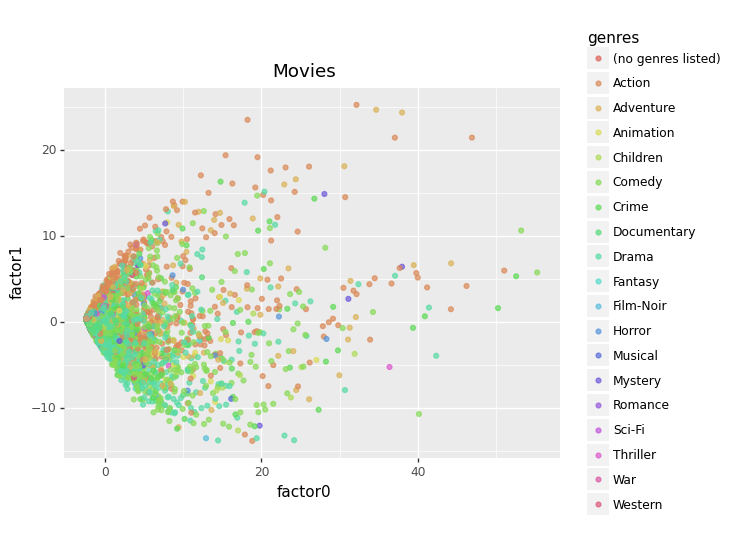

<ggplot: (292668269)>

In [38]:
movies = pd.read_csv('movies.csv')
movies['genres'] = movies.genres.str.split('|').str.get(0)
dic = pd.Series(movies.genres.values,index=movies.movieId.values).to_dict()
genres = pd.Series(movieId).map(dic).values
df['genres'] = genres

ggplot(df) + geom_point(aes(x='factor0', y='factor1', color='genres'), alpha=0.7) + ggtitle('Movies')

##### Observations of graph above:
- The majority of data points seem to be close to (0,0) and there are outliers that spread out from the origin.
- This makes sense because many of the original points in the data set were NAs (i.e. 0's).
- Green colors (Comedy, Crime, Documentary) seem to have more outliers towards the bottom of the graph while (Action, Adventure) have more outliers towards the top of the graph
- The groups do not seem to be very concentrated by group. That is, there is not a significant visual group assignment.

#### number of components

In [39]:
def findNumComponents(var):
    for i in range(170, 180):
        pca = decomposition.PCA(n_components=i)
        s = sum(pca.fit(ratings_scaled).explained_variance_ratio_)*100
        if s >= var:
            return i
    return -1

principalComponents = findNumComponents(var=80)
print('Number of principal components needed to explain 80%% of the variance of the data is %d.' %(principalComponents))


Number of principal components needed to explain 80% of the variance of the data is 176.


## Clustering

#### kmeans inertia

In [40]:
clust = ratings1
ks = [2, 4, 8, 16, 32]
inertia = []
for k in ks:
    kmeans = KMeans(k).fit(clust)
    inertia.append(kmeans.inertia_)

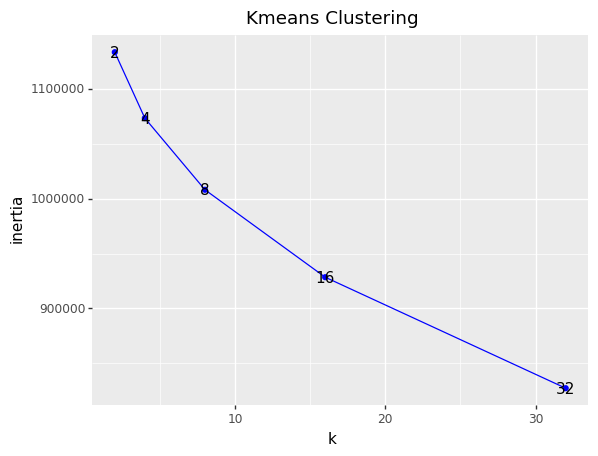

<ggplot: (292667814)>

In [41]:
kplot = pd.DataFrame({'k': ks, 'inertia': inertia})
ggplot(kplot) + geom_point(aes(x='k', y='inertia'), color='blue') + \
geom_line(aes(x='k', y='inertia'), color='blue') +\
geom_text(aes(x='k', y='inertia', label='k')) + ggtitle('Kmeans Clustering')

#### Choice of k
- I choose k=8 because it seems to be at the elbow of the graph.
- It is a good mix of low inertia and low k.
- There are about 19 genres. To me, it makes sense that there would be about 8 groups. Each group containing a few genres that are common within that group.

#### k=8

In [42]:
kmeans = KMeans(8).fit(clust)
cluster_map = pd.DataFrame()
cluster_map['data_index'] = clust.index.values
cluster_map['cluster'] = kmeans.labels_

def getTopMovies(c):
    t = cluster_map[cluster_map.cluster == c]
    df = clust[clust.index.isin(t['data_index'])].mean()
    df = pd.DataFrame(df).reset_index().drop('level_0', axis=1)
    df.columns = ['movieId', 'avg']
    top = df.nlargest(3, 'avg')['movieId'].values
    final = movies[movies['movieId'].isin(top)]
    final = final.copy()
    final['rank'] = np.arange(1, len(final)+1)
    return(final[['rank', 'title', 'genres']])
    

In [43]:
print('TOP MOVIES FOR EACH CLUSTER\n')
for i in range(0, 8):
    print('Cluster = %d' %i)
    print(getTopMovies(i), end='\n\n')


TOP MOVIES FOR EACH CLUSTER

Cluster = 0
      rank                title  genres
266      1  Pulp Fiction (1994)  Comedy
2062     2   Matrix, The (1999)  Action
2374     3    Fight Club (1999)  Action

Cluster = 1
     rank                                              title  genres
232     1          Star Wars: Episode IV - A New Hope (1977)  Action
953     2  Star Wars: Episode V - The Empire Strikes Back...  Action
955     3  Raiders of the Lost Ark (Indiana Jones and the...  Action

Cluster = 2
    rank                                              title genres
21     1                                     Copycat (1995)  Crime
24     2                           Leaving Las Vegas (1995)  Drama
29     3  Shanghai Triad (Yao a yao yao dao waipo qiao) ...  Crime

Cluster = 3
     rank                                      title     genres
0       1                           Toy Story (1995)  Adventure
15      2                              Casino (1995)      Crime
232     3  Star Wars: Ep

##### Observations of clusters above:
- Within each group, for the most part, the movies seem to be similar.
- The genres aline up as well.
- Cluster=1 is definatley a group of users who enjoy action movies (Star Wars in particular).
- Gruops seem to me clustered in a practical fashion and groups seem to have similar genres.
- By observation, *Pulp Fiction* is a popular number 1 choice across all groups which tells me that it is a popular movie in general and almost all types of users will enjoy it.
- *Star Wars: Episode IV - A New Hope* is a popular movie as well among groups 2,5,7.

### Singular Value Decomposition

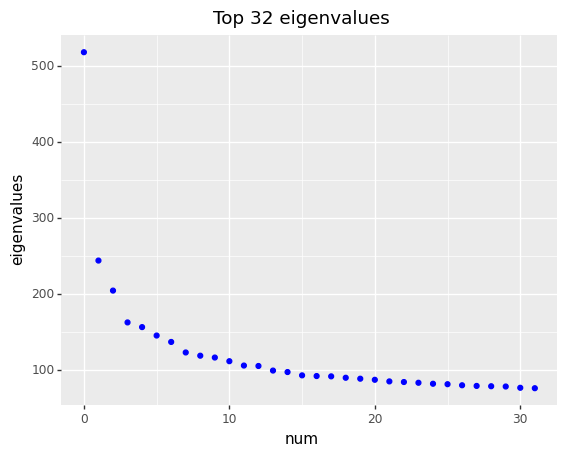

<ggplot: (292871262)>

In [44]:
k=32
svd = decomposition.TruncatedSVD(k)
sinval = svd.fit(clust).singular_values_
Snew = pd.DataFrame({'num': np.arange(0,32), 'eigenvalues': sinval})
ggplot(Snew) + geom_point(aes(x='num', y='eigenvalues'), color='blue') + ggtitle('Top %d eigenvalues' %k)

In [45]:
def getSumVarianceExplained(k):
    svd = decomposition.TruncatedSVD(k)
    return sum(svd.fit(clust).explained_variance_ratio_)
v = []
for k in ks:
    v.append(getSumVarianceExplained(k))
sum_variance = pd.DataFrame({'k': ks, 'sum_var_explained': v})
sum_variance['change'] = sum_variance['sum_var_explained'] - sum_variance['sum_var_explained'].shift(1)
sum_variance

,k,sum_var_explained,change
0,2,0.159801,NaN
1,4,0.212186,0.052386
2,8,0.276265,0.064079
3,16,0.348920,0.072655
4,32,0.439378,0.090458


##### How does this compare?
- k=8 explains about 28% of the variance.
- This is a low percentage but it is also because k=8 is a relatively low value of k which corresponds to a more complex model. 
- Ideally, the sum variance explained would be higher for all groups. That way, a certain number of groups could explain more of the variance, thus, making dimensionality reduction more acccurate.
- k=16 explains more variance. On the other hand, it is a large value of k and may not make practical sense.
- I am looking for a middle choice of k which has lower inertia and higher sum variance explained.
- Comparing to the inertia of k=8, the jump between k=8 and k=16 for inertia is the first "large" jump in my opinion which signifies that k=8 is the correct choice.

In [46]:
svd = decomposition.TruncatedSVD(2)
transform = pd.DataFrame(svd.fit_transform(clust), columns=['factor0', 'factor1'])

In [47]:
transform['cluster'] = kmeans.labels_

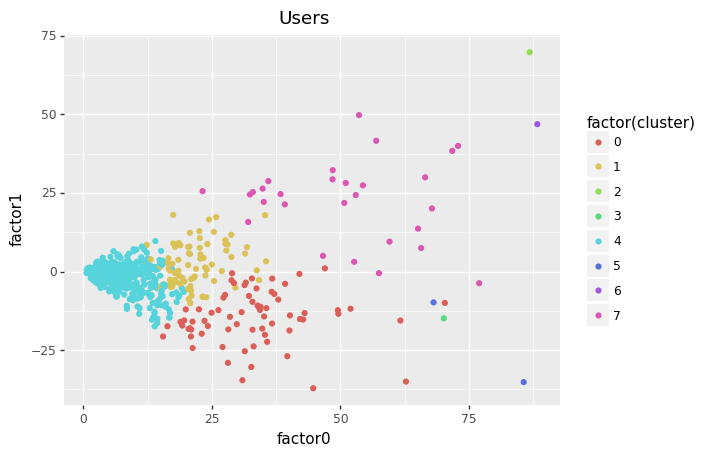

<ggplot: (292528514)>

In [48]:
ggplot(transform) + geom_point(aes(x='factor0', y='factor1', color='factor(cluster)')) +\
ggtitle('Users')

##### Observations
- There are 8 groups here.
- This clustering seems to split up the groups in a practical fashion.
- Those users being outliers are correctly grouped by location in the graph. (grouped by similar in vectors from SVD).
- PCA clustering was focussed on movie groupings. SVD was more focussed on user groupings.
- It makes sense to consider both groupings with the goal to provide accurate suggestions to users.
- In my mind, SVD makes more sense because each group of users should recieve similar suggestions.
